In [1]:
import openmc


In [2]:

###############################################################################
#                      Simulation Input File Parameters
###############################################################################

# OpenMC simulation parameters
batches = 10
inactive = 2
particles = 1000





In [3]:

###############################################################################
#                 Exporting to OpenMC materials.xml file
###############################################################################


# Instantiate some Materials and register the appropriate Nuclides
uo2 = openmc.Material(material_id=1, name='UO2 fuel at 2.4% wt enrichment')
uo2.set_density('g/cm3', 10.29769)
uo2.add_element('U', 1., enrichment=2.4)
uo2.add_element('O', 2.)

helium = openmc.Material(material_id=2, name='Helium for gap')
helium.set_density('g/cm3', 0.001598)
helium.add_element('He', 2.4044e-4)

zircaloy = openmc.Material(material_id=3, name='Zircaloy 4')
zircaloy.set_density('g/cm3', 6.55)
zircaloy.add_element('Sn', 0.014  , 'wo')
zircaloy.add_element('Fe', 0.00165, 'wo')
zircaloy.add_element('Cr', 0.001  , 'wo')
zircaloy.add_element('Zr', 0.98335, 'wo')

borated_water = openmc.Material(material_id=4, name='Borated water')
borated_water.set_density('g/cm3', 0.740582)
borated_water.add_element('B', 4.0e-5)
borated_water.add_element('H', 5.0e-2)
borated_water.add_element('O', 2.4e-2)
borated_water.add_s_alpha_beta('c_H_in_H2O')

# Instantiate a Materials collection and export to XML
materials_file = openmc.Materials([uo2, helium, zircaloy, borated_water])
materials_file.export_to_xml()




In [4]:
###############################################################################
#                 Exporting to OpenMC geometry.xml file
###############################################################################

# Instantiate ZCylinder surfaces
fuel_or = openmc.ZCylinder(surface_id=1, x0=0, y0=0, r=0.39218, name='Fuel OR')
clad_ir = openmc.ZCylinder(surface_id=2, x0=0, y0=0, r=0.40005, name='Clad IR')
clad_or = openmc.ZCylinder(surface_id=3, x0=0, y0=0, r=0.45720, name='Clad OR')
left = openmc.XPlane(surface_id=4, x0=-0.62992, name='left')
right = openmc.XPlane(surface_id=5, x0=0.62992, name='right')
bottom = openmc.YPlane(surface_id=6, y0=-0.62992, name='bottom')
top = openmc.YPlane(surface_id=7, y0=0.62992, name='top')

left.boundary_type = 'reflective'
right.boundary_type = 'reflective'
top.boundary_type = 'reflective'
bottom.boundary_type = 'reflective'

# Instantiate Cells
fuel = openmc.Cell(cell_id=1, name='cell 1')
gap = openmc.Cell(cell_id=2, name='cell 2')
clad = openmc.Cell(cell_id=3, name='cell 3')
water = openmc.Cell(cell_id=4, name='cell 4')

# Use surface half-spaces to define regions
fuel.region = -fuel_or
gap.region = +fuel_or & -clad_ir
clad.region = +clad_ir & -clad_or
water.region = +clad_or & +left & -right & +bottom & -top

# Register Materials with Cells
fuel.fill = uo2
gap.fill = helium
clad.fill = zircaloy
water.fill = borated_water

# Instantiate Universe
root = openmc.Universe(universe_id=0, name='root universe')

# Register Cells with Universe
root.add_cells([fuel, gap, clad, water])

# Instantiate a Geometry, register the root Universe, and export to XML
geometry = openmc.Geometry(root)
geometry.export_to_xml()




In [5]:
###############################################################################
#                   Exporting to OpenMC settings.xml file
###############################################################################

# Instantiate a Settings object, set all runtime parameters, and export to XML
settings_file = openmc.Settings()
settings_file.batches = batches
settings_file.inactive = inactive
settings_file.particles = particles

# Create an initial uniform spatial source distribution over fissionable zones
bounds = [-0.62992, -0.62992, -1, 0.62992, 0.62992, 1]
uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:], only_fissionable=True)
settings_file.source = openmc.source.Source(space=uniform_dist)

entropy_mesh = openmc.RegularMesh()
entropy_mesh.lower_left = [-0.39218, -0.39218, -1.e50]
entropy_mesh.upper_right = [0.39218, 0.39218, 1.e50]
entropy_mesh.dimension = [10, 10, 1]
settings_file.entropy_mesh = entropy_mesh
settings_file.export_to_xml()



In [6]:

###############################################################################
#                   Exporting to OpenMC tallies.xml file
###############################################################################

# Instantiate a tally mesh
mesh = openmc.RegularMesh()
mesh.dimension = [100, 100, 1]
mesh.lower_left = [-0.62992, -0.62992, -1.e50]
mesh.upper_right = [0.62992, 0.62992, 1.e50]

# Instantiate some tally Filters
energy_filter = openmc.EnergyFilter([0., 4., 20.e6])
mesh_filter = openmc.MeshFilter(mesh)

# Instantiate the Tally
tally = openmc.Tally(tally_id=1, name='tally 1')
tally.filters = [energy_filter, mesh_filter]
tally.scores = ['flux', 'fission', 'nu-fission']

# Instantiate a Tallies collection and export to XML
tallies_file = openmc.Tallies([tally])
tallies_file.export_to_xml()

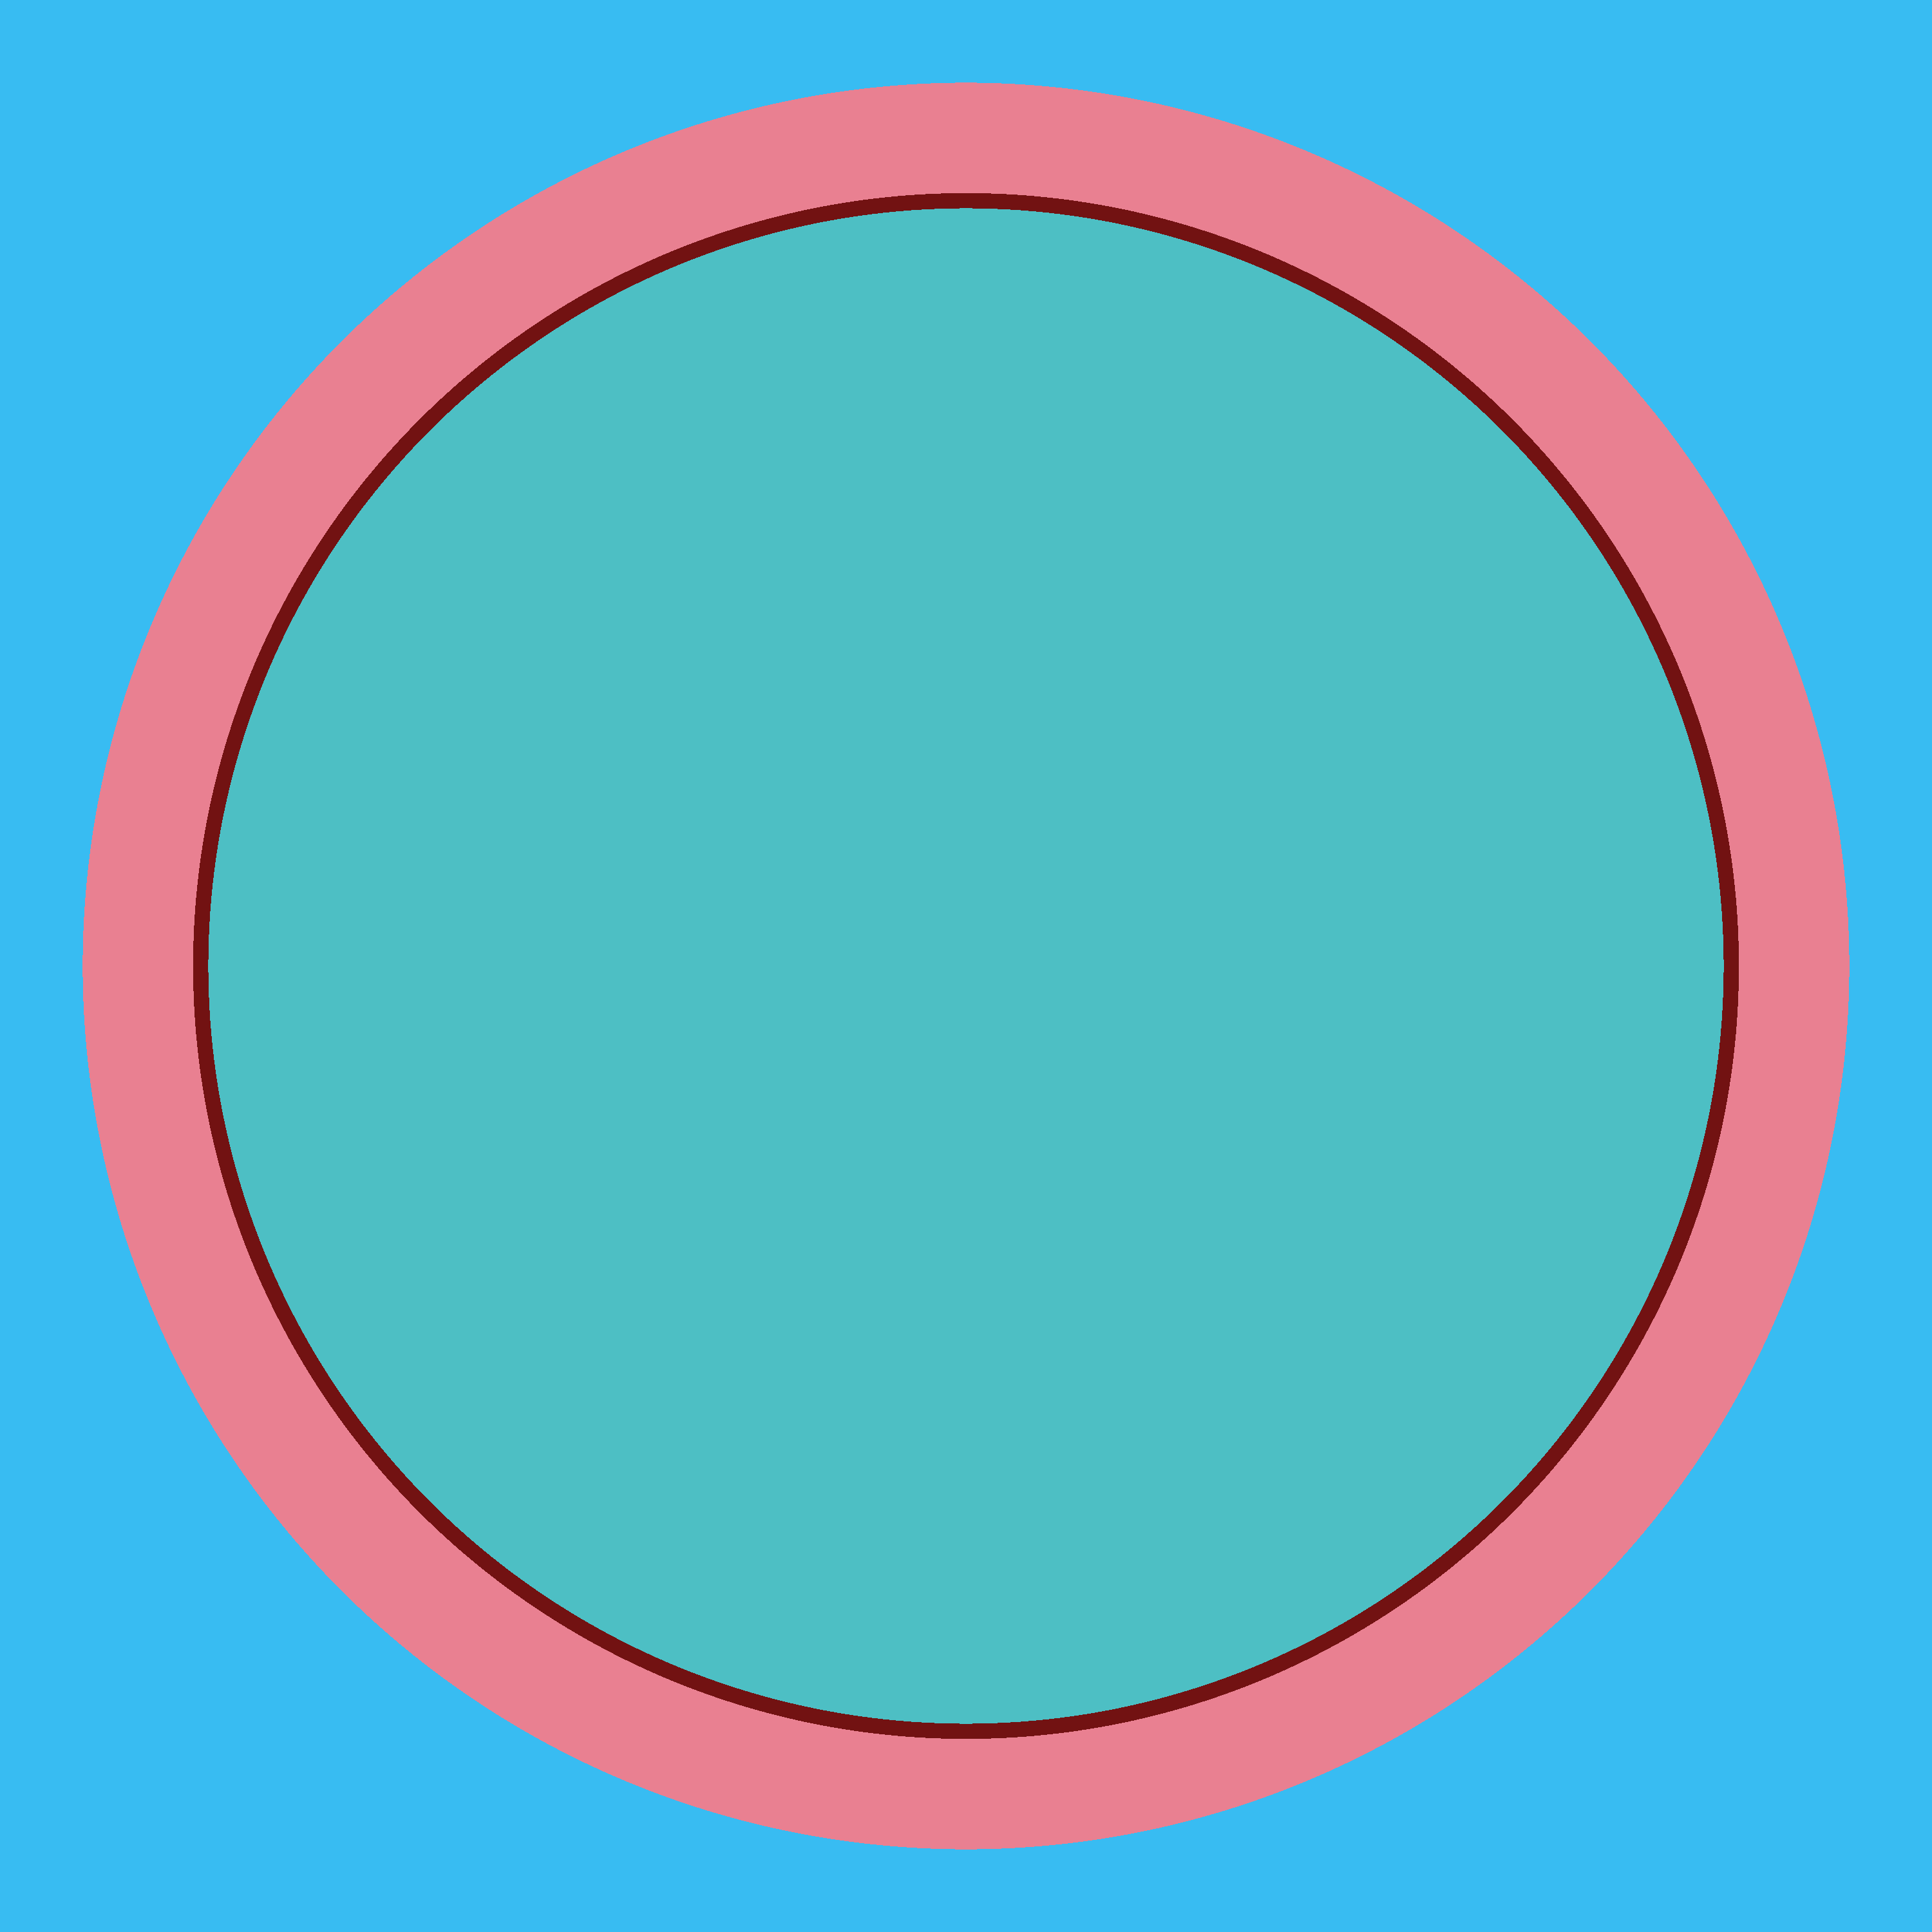

In [10]:
plot1 = openmc.Plot()
plot1.filename = 'materials-xy'
plot1.origin = [0, 0, 0]
plot1.basis = 'xy'
plot1.width = [1.0, 1.0]
plot1.pixels = [3000, 3000]
plot1.color = "material"

# Plot inline in jupyter or QtConsole
openmc.plot_inline(plot1)

In [11]:
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################